In [2]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Definir dispositivo (usando GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Función de preprocesamiento
def load_and_preprocess_data(csv_path):
    tweets_df = pd.read_csv(csv_path, encoding="ISO-8859-1", header=None)
    tweets_df.columns = ["sentiment", "id", "date", "flag", "user", "text"]
    tweets_df['sentiment'] = tweets_df['sentiment'].map({0: 0, 4: 1})
    tweets_df = tweets_df[["text", "sentiment"]]
    return tweets_df

# Cargar y procesar datos
tweets_df = load_and_preprocess_data("training.1600000.processed.noemoticon.csv")
tweets_df.to_csv("train-processed.csv", index=False)

# División de datos
df = pd.read_csv("train-processed.csv")
train_data, temp_data = train_test_split(df, test_size=0.1, random_state=ord("H"))
test_data, valid_data = train_test_split(temp_data, test_size=0.5, random_state=ord("H"))


Using device: cuda


In [3]:
class TweetsDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]["text"]
        label = self.data.iloc[idx]["sentiment"]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Cargar el tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Crear Datasets y DataLoaders
train_dataset = TweetsDataset(train_data, tokenizer)
valid_dataset = TweetsDataset(valid_data, tokenizer)
test_dataset  = TweetsDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Cargar el modelo de BERT para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Definir optimizador y scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

criterion = torch.nn.CrossEntropyLoss()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_train_loss += loss.item()
            total_train_correct += (logits.argmax(dim=1) == labels).sum().item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / len(train_loader.dataset)
        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Training loss: {avg_train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
        
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        
        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits
                
                total_val_loss += loss.item()
                total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(valid_loader)
        val_accuracy = total_val_correct / len(valid_loader.dataset)
        
        print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")


In [6]:
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs)


  0%|          | 0/45000 [00:00<?, ?it/s]C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 45000/45000 [5:53:07<00:00,  2.12it/s]  


Epoch 1/3
Training loss: 0.3237, Training accuracy: 0.8598
Validation loss: 0.2931, Validation accuracy: 0.8757


100%|██████████| 45000/45000 [12:53:46<00:00,  1.03s/it]        


Epoch 2/3
Training loss: 0.2570, Training accuracy: 0.8929
Validation loss: 0.2924, Validation accuracy: 0.8796


100%|██████████| 45000/45000 [5:58:45<00:00,  2.09it/s]   


Epoch 3/3
Training loss: 0.1984, Training accuracy: 0.9203
Validation loss: 0.3179, Validation accuracy: 0.8779


In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = logits.argmax(dim=1)
            
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')
    
    return all_labels, all_preds

labels, preds = evaluate_model(model, test_loader)


Test Accuracy: 0.8763


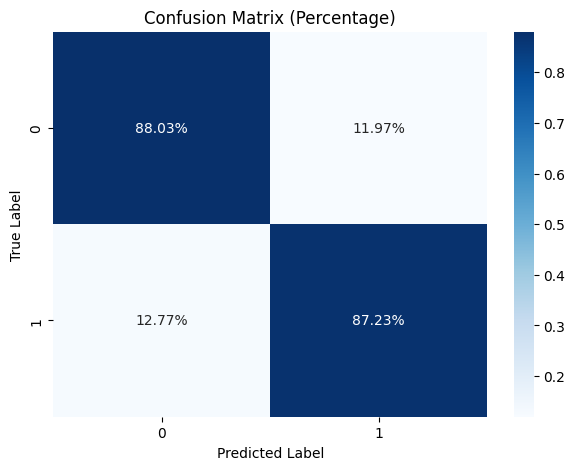

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Asegúrate de importar numpy
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Percentage)')
    plt.savefig('confusion_matrix_transformer.png')
    plt.show()

plot_confusion_matrix(labels, preds)


In [11]:
def predict_sentiment(model, text, tokenizer, max_len=128):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = output.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
    
    return predicted_class, probs.squeeze().tolist()

new_tweet = "I like that car"
predicted_class, probabilities = predict_sentiment(model, new_tweet, tokenizer)
print(f"Predicted Sentiment: {predicted_class} (0: Negative, 1: Positive)")
print(f"Class Probabilities: {probabilities}")


Predicted Sentiment: 1 (0: Negative, 1: Positive)
Class Probabilities: [0.04915699362754822, 0.9508430361747742]
